# Solar Power Generation Prediction
Submission Notebook

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib


## Load and Inspect Data

In [18]:
df = pd.read_csv('solarpowergeneration.csv')
print(df.head())
print(df.info())


   distance-to-solar-noon  temperature  wind-direction  wind-speed  sky-cover  \
0                0.859897           69              28         7.5          0   
1                0.628535           69              28         7.5          0   
2                0.397172           69              28         7.5          0   
3                0.165810           69              28         7.5          0   
4                0.065553           69              28         7.5          0   

   visibility  humidity  average-wind-speed-(period)  \
0        10.0        75                          8.0   
1        10.0        77                          5.0   
2        10.0        70                          0.0   
3        10.0        33                          0.0   
4        10.0        21                          3.0   

   average-pressure-(period)  power-generated  
0                      29.82                0  
1                      29.85                0  
2                      29.89    

## Data Cleaning

In [19]:
df['average-wind-speed-(period)'] = df['average-wind-speed-(period)'].fillna(df['average-wind-speed-(period)'].median())


## Feature Engineering

In [20]:
df['log_power_generated'] = np.log1p(df['power-generated'])
df['solar_proximity'] = 1 - df['distance-to-solar-noon']


## EDA

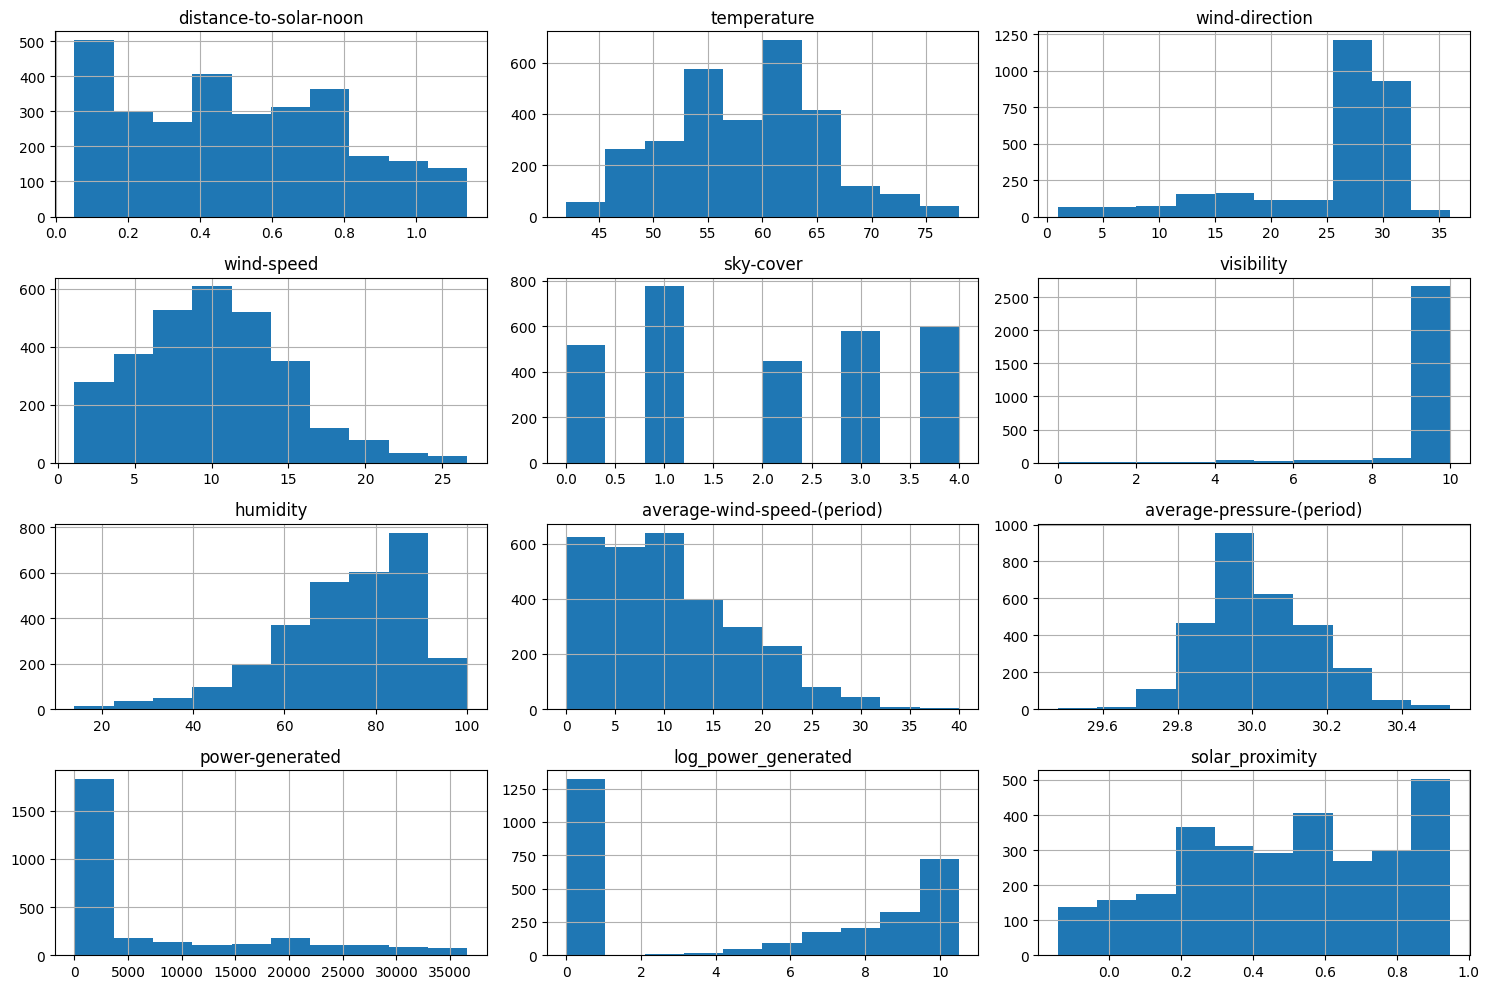

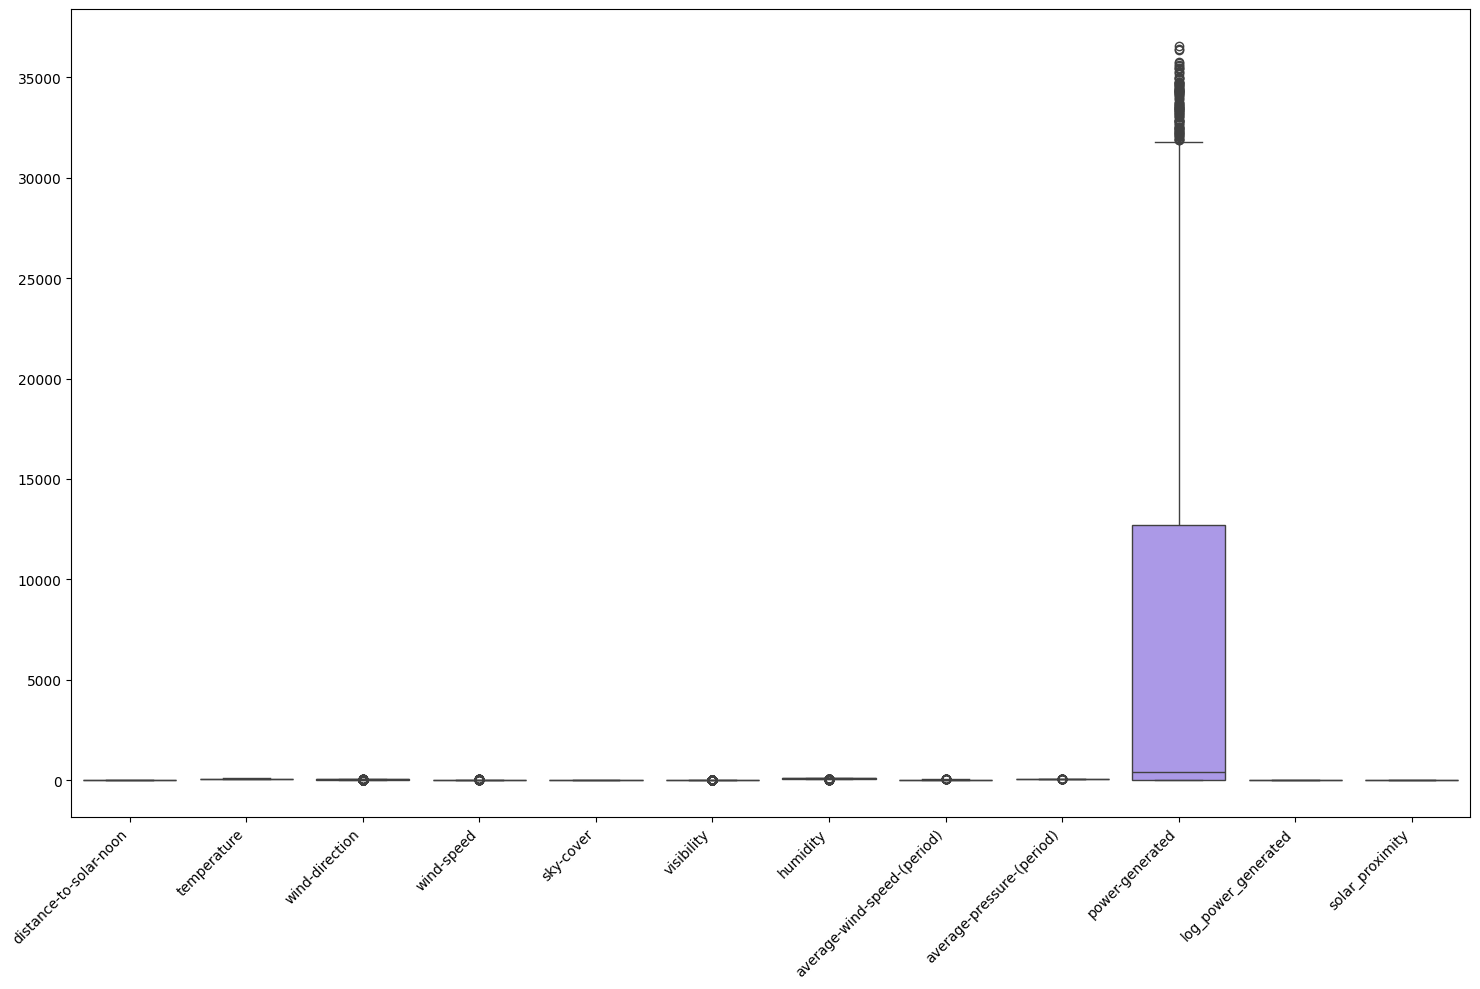

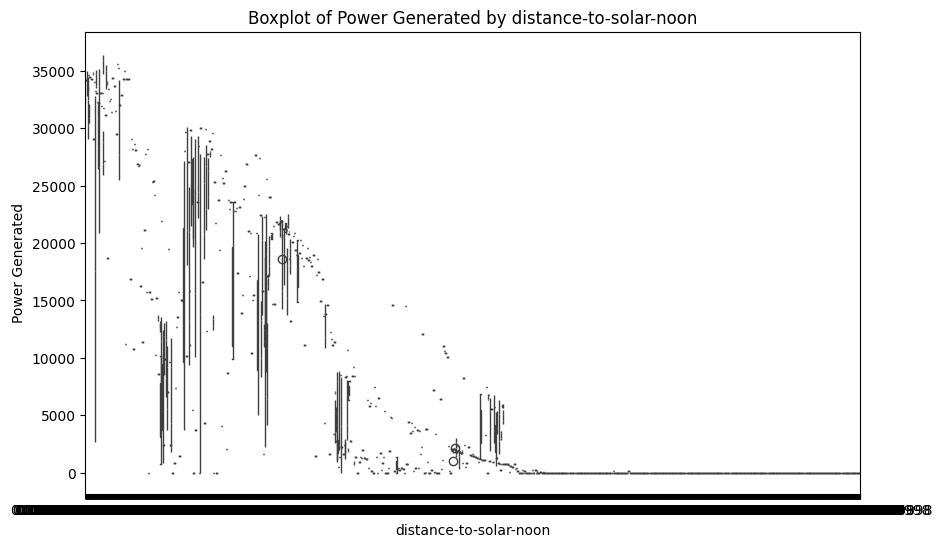

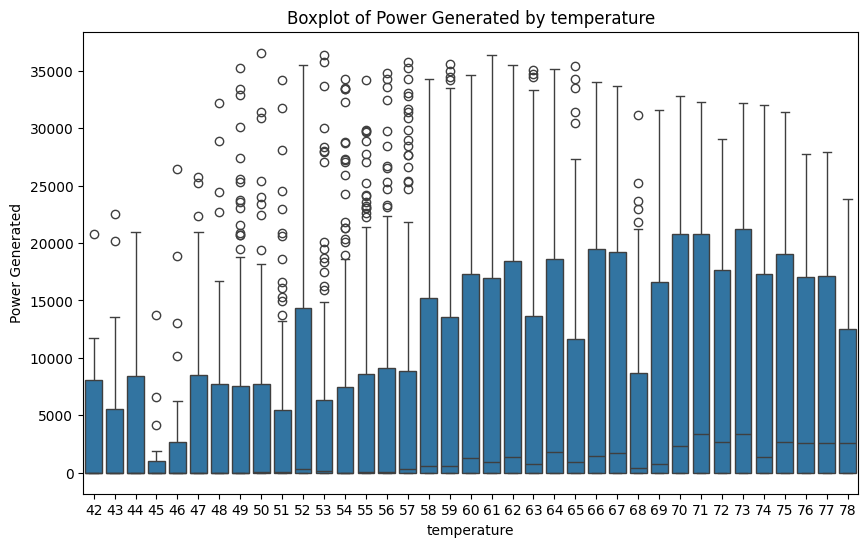

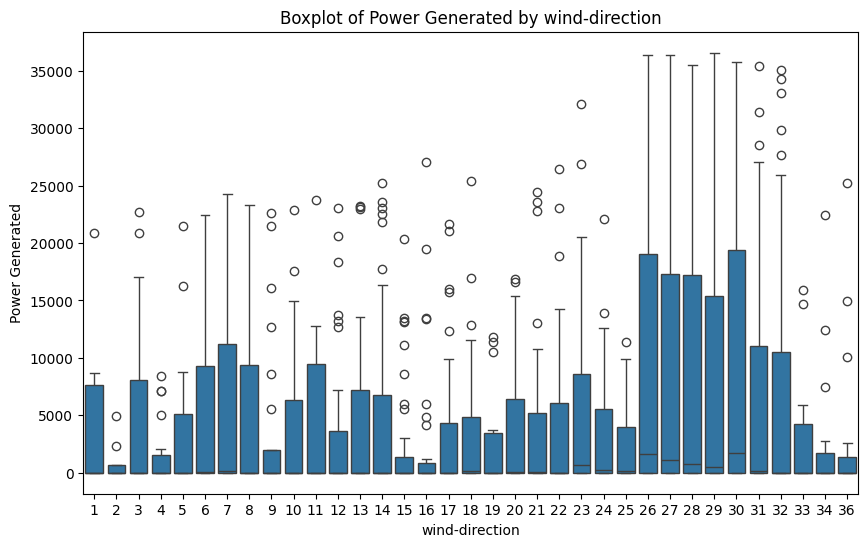

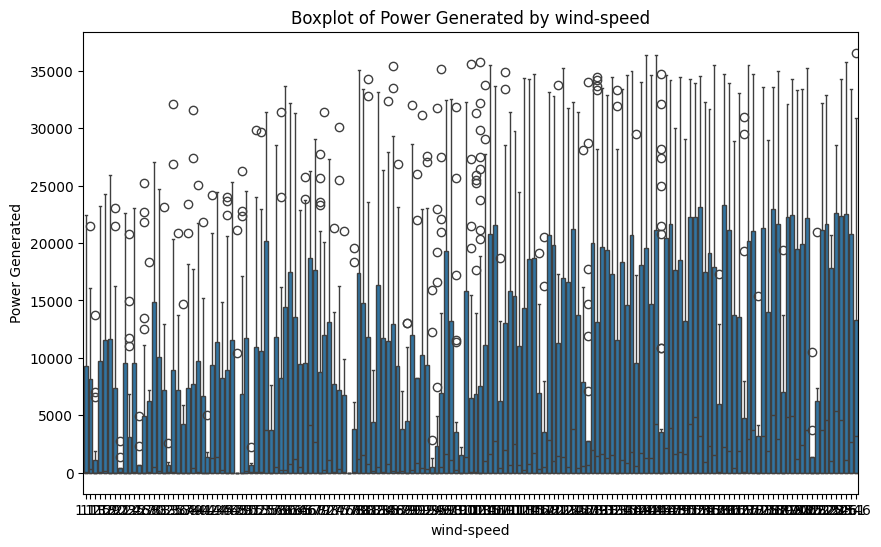

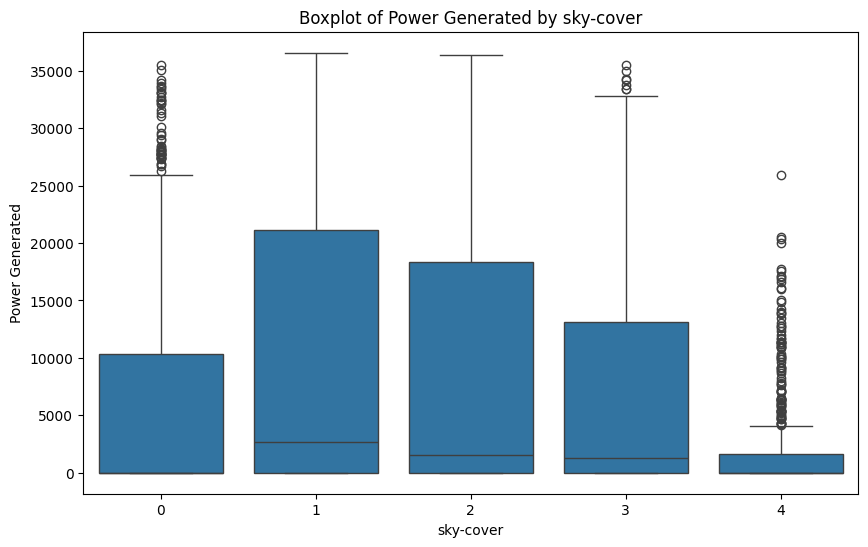

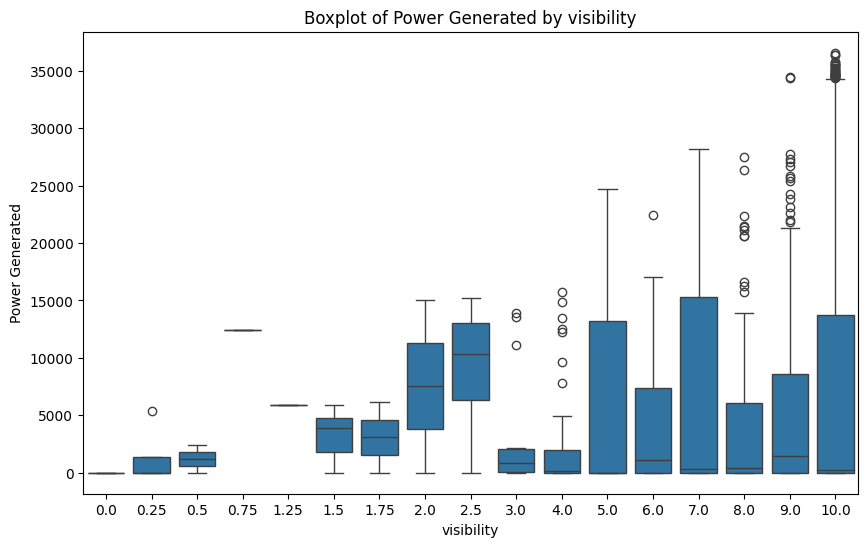

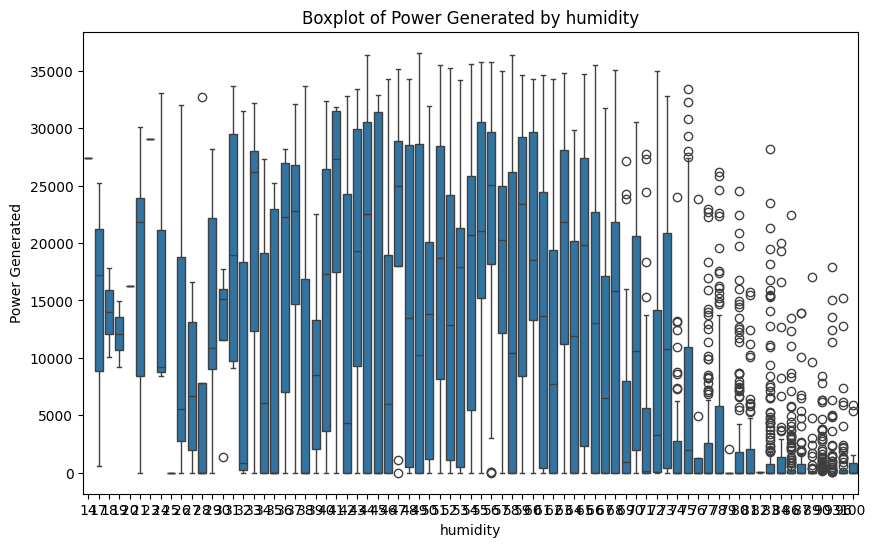

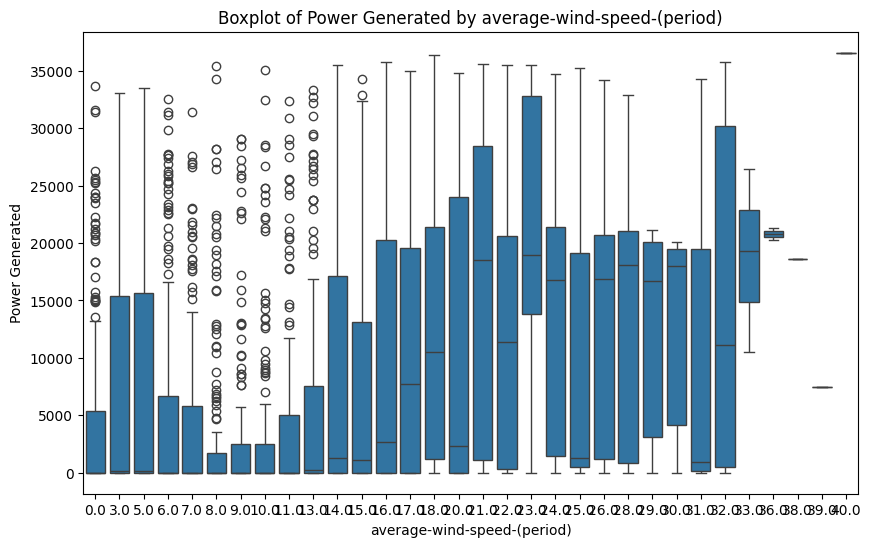

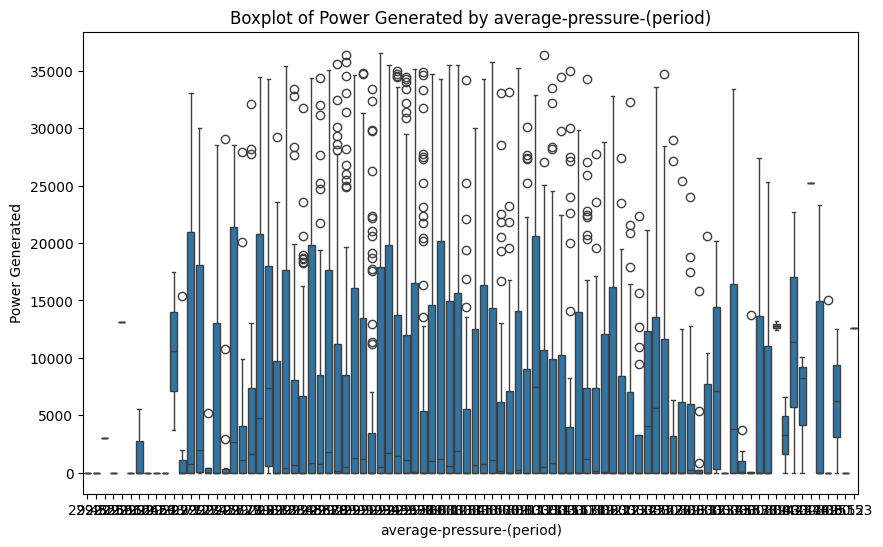

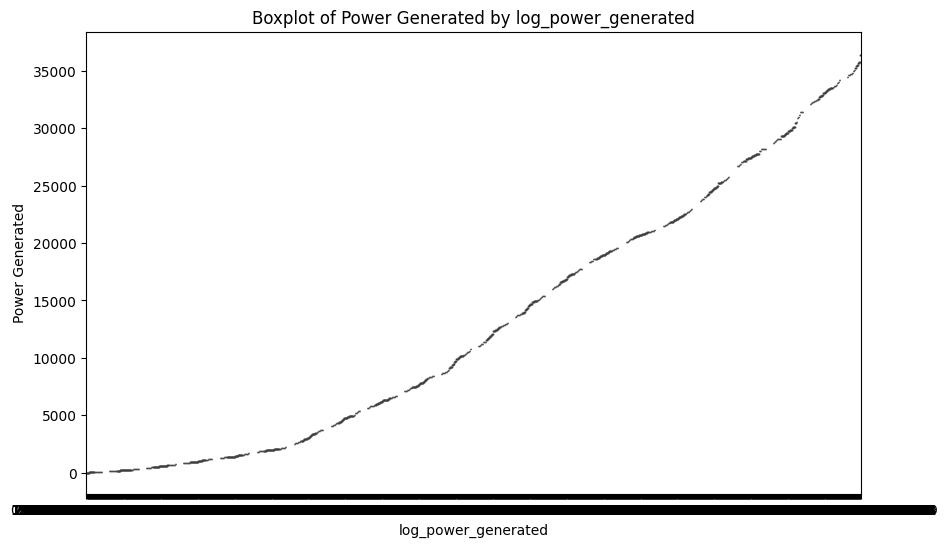

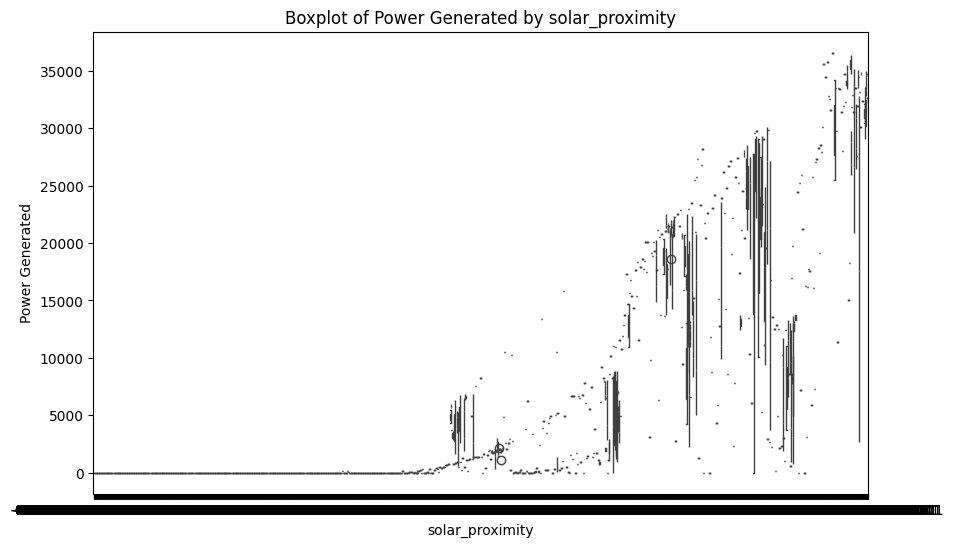

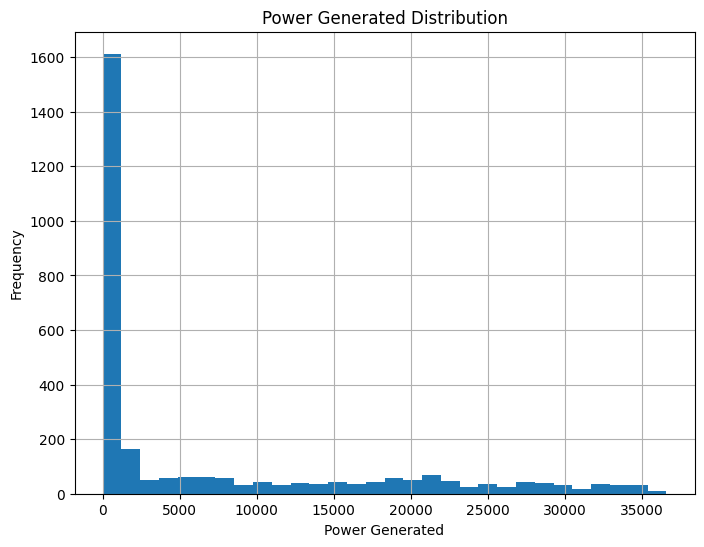

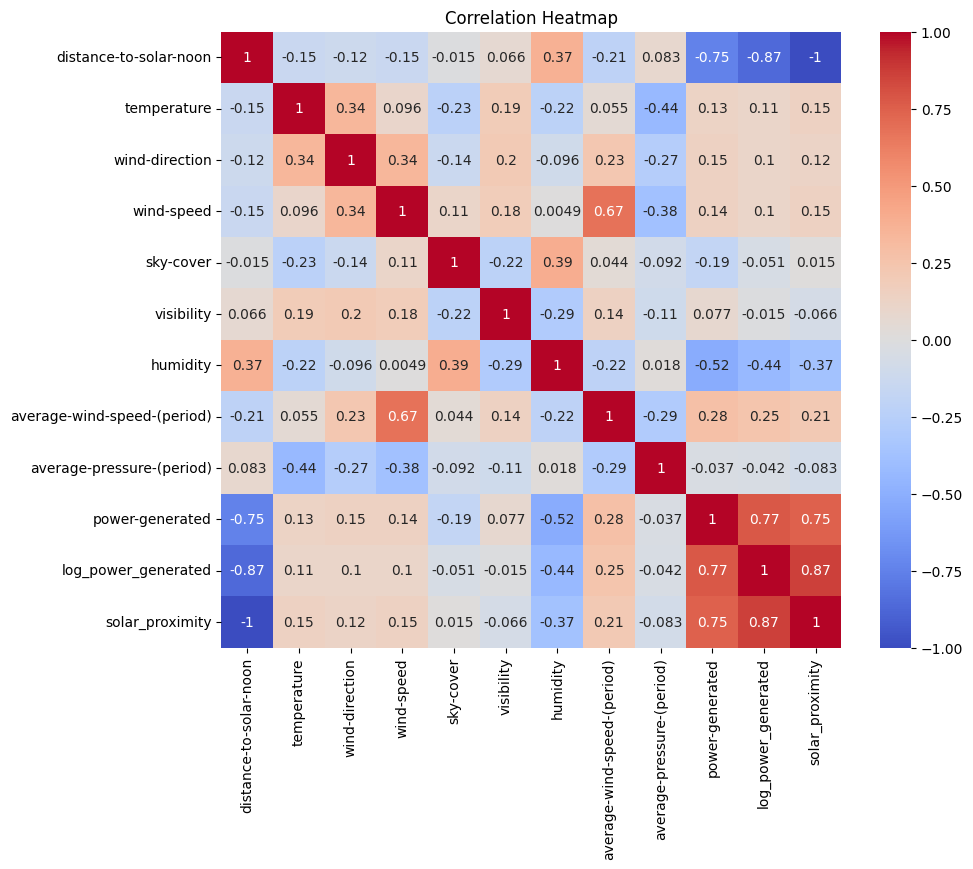

In [35]:
# Histograms for numerical features
df.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

# Boxplots for numerical features
plt.figure(figsize=(15, 10))
sns.boxplot(data=df)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Boxplots for numerical features vs target
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
numerical_cols.remove('power-generated') # Exclude target variable

for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=col, y='power-generated', data=df)
    plt.title(f'Boxplot of Power Generated by {col}')
    plt.xlabel(col)
    plt.ylabel('Power Generated')
    plt.show()

plt.figure(figsize=(8,6))
df['power-generated'].hist(bins=30)
plt.title('Power Generated Distribution')
plt.xlabel('Power Generated')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Train-Test Split

In [22]:
feature_columns = [
    'distance-to-solar-noon', 'temperature', 'wind-direction', 'wind-speed',
    'sky-cover', 'visibility', 'humidity',
    'average-wind-speed-(period)', 'average-pressure-(period)', 'solar_proximity'
]

X = df[feature_columns]

y = df['log_power_generated']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Model Training

In [23]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test)

print(f"MSE: {mean_squared_error(y_test_actual, y_pred):.2f}")
print(f"R2 Score: {r2_score(y_test_actual, y_pred):.2f}")


MSE: 13488928.04
R2 Score: 0.87


## Save Model

In [24]:
joblib.dump(model, 'solar_power_model.pkl')


['solar_power_model.pkl']

In [25]:
# Import necessary libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Split the data (you can skip if already done)
X = df.drop('power-generated', axis=1)
y = df['power-generated']

# Log transformation if not already applied
y_log = np.log1p(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Dictionary to store model results
results = {}

# 1. Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
results['Linear Regression'] = {
    'MSE': mean_squared_error(y_test, y_pred_lr),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_lr)),
    'R2': r2_score(y_test, y_pred_lr)
}

# 2. Random Forest (default)
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
results['Random Forest'] = {
    'MSE': mean_squared_error(y_test, y_pred_rf),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_rf)),
    'R2': r2_score(y_test, y_pred_rf)
}

# 3. XGBoost
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
results['XGBoost'] = {
    'MSE': mean_squared_error(y_test, y_pred_xgb),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
    'R2': r2_score(y_test, y_pred_xgb)
}

# Display results
results_df = pd.DataFrame(results).T
print("Model Comparison Results (on log-transformed target):")
display(results_df)


Model Comparison Results (on log-transformed target):


,MSE,RMSE,R2
Linear Regression,3.588325e-29,5.990263e-15,1.000000
Random Forest,1.813421e-04,1.346633e-02,0.999991
XGBoost,6.142682e-04,2.478443e-02,0.999969


In [26]:
pip install streamlit

In [27]:
import streamlit as st
import numpy as np
import pandas as pd
import joblib

# Load the trained model
model = joblib.load("solar_power_model.pkl")

# Title
st.title("🔆 Solar Power Prediction App")
st.write("Predict solar energy generation (in Joules per 3 hours) using weather data.")

# Sidebar for inputs
st.sidebar.header("Input Features")

# User inputs
distance_to_solar_noon = st.sidebar.slider("Distance to Solar Noon (0 to 1)", 0.0, 1.0, 0.5)
temperature = st.sidebar.number_input("Temperature (°C)", value=25.0)
wind_direction = st.sidebar.slider("Wind Direction (0 to 360 degrees)", 0, 360, 180)
wind_speed = st.sidebar.number_input("Wind Speed (m/s)", value=3.0)
sky_cover = st.sidebar.slider("Sky Cover (0: clear - 4: covered)", 0, 4, 2)
visibility = st.sidebar.number_input("Visibility (km)", value=10.0)
humidity = st.sidebar.slider("Humidity (%)", 0, 100, 50)
average_wind_speed = st.sidebar.number_input("Average Wind Speed (m/s)", value=3.5)
average_pressure = st.sidebar.number_input("Average Pressure (inHg)", value=29.5)

# Derived feature
solar_proximity = 1 - distance_to_solar_noon

# Predict button
if st.button("Predict Solar Power Output"):
    # Create input array in the correct order
    input_data = np.array([[distance_to_solar_noon, temperature, wind_direction, wind_speed,
                            sky_cover, visibility, humidity, average_wind_speed,
                            average_pressure, solar_proximity]])

    # Predict log-transformed output
    prediction_log = model.predict(input_data)[0]

    # Convert back using expm1
    prediction_joules = np.expm1(prediction_log)

    # Show result
    st.success(f"🔋 Predicted Power Generated: **{prediction_joules:,.2f} Joules**")


2025-07-10 07:42:43.323 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 07:42:43.336 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 07:42:43.338 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 07:42:43.341 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 07:42:43.342 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 07:42:43.343 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 07:42:43.349 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 07:42:43.350 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [28]:
import joblib
joblib.dump(rf, 'solar_power_model.pkl')  # rf is your RandomForestRegressor model


['solar_power_model.pkl']

In [29]:
print(X.columns.tolist())

['distance-to-solar-noon', 'temperature', 'wind-direction', 'wind-speed', 'sky-cover', 'visibility', 'humidity', 'average-wind-speed-(period)', 'average-pressure-(period)', 'log_power_generated', 'solar_proximity']


In [30]:
import joblib

# Define the features used in the model
features = [
    'distance-to-solar-noon',
    'temperature',
    'humidity',
    'wind-speed',
    'sky-cover',
    'visibility',
    'average-wind-speed-(period)',
    'average-pressure-(period)',
    'solar_proximity',
    'wind-direction'
]

# Save the feature list
joblib.dump(features, 'features.pkl')

['features.pkl']

In [31]:
model = RandomForestRegressor()
model.fit(df[features], df['log_power_generated'])

# Save model
joblib.dump(model, 'solar_power_model.pkl')


['solar_power_model.pkl']

In [32]:
import streamlit as st
import pandas as pd
import numpy as np
import joblib

# Load model and feature list
model = joblib.load("solar_power_model.pkl")
features = joblib.load("features.pkl")  # List of exact features used during training

st.title("🔆 Solar Power Prediction App")

# Inputs
distance = st.slider("Distance to Solar Noon", 0.0, 1.0, 0.5)
temperature = st.number_input("Temperature (°C)", 0.0, 50.0, 25.0)
humidity = st.slider("Humidity (%)", 0, 100, 50)
wind_speed = st.number_input("Wind Speed (m/s)", 0.0, 20.0, 5.0)
sky_cover = st.slider("Sky Cover (0 to 4)", 0, 4, 2)
visibility = st.number_input("Visibility (km)", 0.0, 50.0, 10.0)
wind_direction = st.number_input("Wind Direction (0–360°)", 0, 360, 180)
pressure = st.number_input("Pressure (inHg)", 25.0, 32.0, 29.92)

# Derived feature
solar_proximity = 1 - distance

# Create feature vector
input_dict = {
    'distance-to-solar-noon': distance,
    'temperature': temperature,
    'humidity': humidity,
    'wind-speed': wind_speed,
    'sky-cover': sky_cover,
    'visibility': visibility,
    'average-wind-speed-(period)': wind_speed,
    'average-pressure-(period)': pressure,
    'solar_proximity': solar_proximity,
    'wind-direction': wind_direction
}

input_data = pd.DataFrame([input_dict])[features]

# Predict
log_pred = model.predict(input_data)
prediction = np.expm1(log_pred)[0]  # Inverse log1p

st.subheader(f"🔋 Predicted Solar Power Output: {prediction:.2f} Joules")


2025-07-10 07:42:45.761 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 07:42:45.762 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 07:42:45.763 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 07:42:45.765 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 07:42:45.766 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 07:42:45.767 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 07:42:45.769 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 07:42:45.770 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()